
### 프로젝트 완성하기 위한 단계

아래 여러 단계로 진행합니다:

* [Step 0](#step0): Dataset 준비하기
* [Step 1](#step1): Create a CNN to Classify (Transfer learning) 
* [Step 2](#step2): Train & Test & Optimaization
* [Step 3](#step3): App

In [1]:
!pip install opencv-python

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install tqdm

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install matplotlib

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import cv2
print(cv2.__version__)

4.5.1


In [5]:
import numpy as np
from glob import glob
import random
import cv2                
import os
from pathlib import Path
from tqdm import tqdm
import torchvision
from torchvision import datasets
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from PIL import ImageFile
from PIL import Image
import IPython
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
<a id='step0'></a>
## Step 0: Dataset 준비하기


1. __images 폴더__는 dataset인 각 건물들을 분류해 놓은 이미지 폴더입니다. 
2. __models 폴더__는 학습된 모델을 저장하기 위한 폴더 입니다.

In [6]:
import random
import numpy as np
from glob import glob

# load filenames for building images
# glob - 해당 경로상 파일이름에 대한 list를 반환
building_files = np.array(glob("HBC-5/*/*/*/*"))

random.shuffle(building_files)


# print number of images in each dataset
print('총 %d 개의 building images가 있습니다.' % len(building_files))

총 10779 개의 building images가 있습니다.


In [7]:
building_files

array(['HBC-5\\images\\train\\3\\img_1575.png',
       'HBC-5\\images\\train\\2\\img_1198.png',
       'HBC-5\\images\\train\\4\\img_847.png', ...,
       'HBC-5\\images\\train\\3\\img_1755.png',
       'HBC-5\\images\\test\\1\\img_99.png',
       'HBC-5\\images\\test\\3\\img_74.png'], dtype='<U33')

In [8]:
def image_loader(img_path, transform, use_cuda):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    return img

In [9]:
## Get Id of default device
torch.cuda.current_device()
# 0
torch.cuda.get_device_name(0)

'GeForce RTX 2060 SUPER'

In [10]:
#  train 이미지의 RGB별 평균과 표준편차를 구하려고 합니다.(Normalize하기 위해서)
use_cuda = torch.cuda.is_available()
newpath = Path("HBC-5/images").expanduser()
train_path = str(newpath.joinpath("train"))
valid_path = str(newpath.joinpath("valid"))
test_path = str(newpath.joinpath("test"))
IMAGE_SIZE = 224

In [11]:
# image file is truncated (150 bytes not processed) 에러가 떠서 해결
    # ImageFile.LOAD_TRUNCATED_IMAGES = True

# normalization을 해주기 위해 mean과 std를 구하려고 합니다.
train_transform =  transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                      transforms.ToTensor()
                                      ])

# train set을 가져오기.
trainset = datasets.ImageFolder(train_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle = False)


# train set의 class의 개수 저장
BUILDING = len(trainset.classes)
print(BUILDING)


# cnt는 이미지의 개수
cnt = 0
mean = 0.
std = 0.
for images, label in trainloader:
    # [20,3,224,224] -> [20,3,224*224] 로 바꿈
    if(use_cuda):
        images = images.cuda()
    images = images.view(images.size(0), images.size(1), -1)

    # batch만큼의  사진의 개수를 count해줌
    cnt += images.size(0)
    # 각 batch당 색깔별 mean, std를 구해 mean, std 변수에 합쳐서 저장
    mean += images.mean(2).sum(0) 
    std += images.std(2).sum(0)
    print(cnt)
# 사진의 개수로 위에서 더한 mean값을 나눠줌
mean /= cnt
std /= cnt

print(mean)
print(std)

5
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7688
tensor([0.3465, 0.3562, 0.3582], device='cuda:0')
tensor([0.1854, 0.1864, 0.1994], device='cuda:0')


In [12]:
BUILDING = len(trainset.classes)
print('Num of classese : ', BUILDING)

Num of classese :  5


---
<a id='step1'></a>
## Step 1: Create a CNN to Classify (Transfer learning) 

### Pre-trained Resnet Model 불러오기


### Transfer learning을 위한 네트워크를 가져옵니다.

In [13]:
model_transfer = models.resnet50(pretrained=True)

In [14]:
# 위에서 구한 mean값과 std값을 MEANS 와 DEVIATIONS 변수에 넣어 줍니다.
MEANS = [0.1854, 0.1864, 0.1994]
DEVIATIONS = [0.3465, 0.3562, 0.3582]

#size 조정과 학습할 때 Normalize에 사용된 mean값과 std값으로 Normalize를 적용해 주었습니다. 
#train_transforms의 경우 각도 변환과, 뒤집기, 자르기를 통해 더 많은 data를 가지는 효과를 냅니다.
transfer_train_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(p=0.5),
                                                transforms.ToTensor(),
                                                transforms.Normalize(MEANS, DEVIATIONS)])

transfer_test_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(MEANS, DEVIATIONS)
                                              ])

# Image folder

transfer_training = datasets.ImageFolder(train_path, transform=transfer_train_transforms)
transfer_validation = datasets.ImageFolder(valid_path, transform=transfer_test_transforms)
transfer_testing = datasets.ImageFolder(test_path, transform=transfer_test_transforms)


# DataLoader

transfer_train_batches =  torch.utils.data.DataLoader(transfer_training, batch_size=128, shuffle = True)
transfer_valid_batches =  torch.utils.data.DataLoader(transfer_validation, batch_size=128, shuffle = False)
transfer_test_batches =  torch.utils.data.DataLoader(transfer_testing, batch_size=128, shuffle = False)


# transfer_model의 Featuer 부분은, training 하지 않기 때문에, 모든 parameter를 동결 시킨 뒤, fc부분을 새로 정의해 줍니다.
for param in model_transfer.parameters():
    param.requires_grad = False

    
# fc부분에 교체할 fc를 만들어 줍니다.
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000)),
                                ('bn1', nn.BatchNorm1d(1000)),
                                ('ReLU', nn.ReLU()),
                                ('fc2', nn.Linear(1000, 700)),
                                ('bn2', nn.BatchNorm1d(700)),
                                ('ReLU', nn.ReLU()),
                                ('dropout', nn.Dropout(0.2)),
                                ('fc3', nn.Linear(700, 200)),
                                ('bn3', nn.BatchNorm1d(200)),
                                ('ReLU', nn.ReLU()),
                                ('fc4', nn.Linear(200, BUILDING))]))

model_transfer.fc = fc

# cuda 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transfer.to(device)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [15]:
# batch당 data의 size를 확인합니다.
a , b = next(iter(transfer_train_batches))
a.size()

torch.Size([128, 3, 224, 224])

## 구성된 네트워크를 확인합니다.

In [16]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<a id='step2'></a>
## Step 2: Train & Test & Optimaization

In [17]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, scheduler, criterion, use_cuda, save_path):
    ### 답 작성 부분 ###

    # 매개변수로 전해 받은 n_epochs를 n_epoch에 저장합니다.
    n_epoch = n_epochs
    
    #plot해서 결과를 확인하기 위해 train loss와 valid loss를 저장할 list를 만들어 줍니다.
    train_losses = []
    valid_losses = []

    #가장 작은 validation loss 값을 저장하기위한 변수를 생성합니다.
    valid_loss_min = np.Inf 

    
    #training을 진행하고, validation loss 구해 보겠습니다.
    for epoch in range(1, n_epoch+1):

        # 확인할 train loss와 validation loss 를 생성합니다.
        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################

        #parameter들을 update 해야하므로, model.train()을 켜 줍니다.
        model.train()

        #train_loader에서 image와 label을 가져옵니다.
        for data, target in tqdm(train_loader):

            # CUDA 가 사용 가능하다면 image와 label을 GPU로 옮깁니다.
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            # gradients 값을 초기화
            optimizer.zero_grad()
          
            # forward pass: train_loader를 통해 가져온 batch를 model에 forward pass 시킵니다.
            output = model(data)
          
            # batch loss를 계산합니다.
            loss = criterion(output, target)
          
            # backward pass: gradient 값을 구합니다.
            loss.backward()
          
            # Optimizer를 돌려서 parameter들을 update합니다.
            optimizer.step()
          
            # batch별 train_loss를 더합니다.
            train_loss += loss.item()*data.size(0)
       
        ######################    
        # validate the model #
        ######################
        
        #parameter들을 update하지 않으므로, model.eval()을 켜 줍니다.
        model.eval()
        
        #valid_loader에서 image와 labe을 가져옵니다.
        for data, target in tqdm(valid_loader):
            
            # CUDA가 사용 가능 하다면 image와 label을 GPU로 옮깁니다.
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # forward pass: valid_loader를 통해 가져온 batch를 model에 forward pass 시킵니다.
            output = model(data)
            
            # Validation loss를 계산합니다.
            loss = criterion(output, target)
            
            # batch별 Validation loss를 더합니다. 
            valid_loss += loss.item()*data.size(0)
    
        scheduler.step()
        # 각 loss 들(모두 더한값) 을 평균을 만들어 줍니다. 
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        #train_loss와 valid_loss를 위에서 생성한 losses list에 저장합니다.
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # epoch별로 train loss와 validation loss를 보여줍니다.
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
        # validation loss가 가장 작은 parameter를 저장합니다.
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    if(epoch>10 and epoch % 3 == 0):
        bre = input(" break? 0 :")
        if(bre == 0):
            return model, train_losses, valid_losses
      
    #학습된 model, 성능을 확인할 train_losses, valid_losses를 반환합니다.        
    return model, train_losses, valid_losses


## optimizer, criterion, scheduler를 설정합니다.

In [18]:
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = optimizer.Adam(model_transfer.parameters(), lr=3e-3)
scheduler_transfer = StepLR(optimizer=optimizer_transfer ,step_size=6, gamma=0.1)

In [19]:
# PIL image가 truncated 된 경우 사용할 수 있도록 설정
ImageFile.LOAD_TRUNCATED_IMAGES = True

#epoch를 설정합니다.
epochs = 20

model_path = Path("HBC-5/models").expanduser()
save_path = model_path.joinpath("model_transfer.pt")

# model_scratch 학습하기
model_transfer, train_losses, valid_losses = train(epochs, transfer_train_batches, transfer_valid_batches, model_transfer, optimizer_transfer, scheduler_transfer, criterion_transfer, use_cuda, save_path)

# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_transfer.load_state_dict(torch.load(save_path))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.30s/it]


Epoch: 1 	Training Loss: 0.169891 	Validation Loss: 0.101589
Validation loss decreased (inf --> 0.101589).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.28s/it]


Epoch: 2 	Training Loss: 0.028700 	Validation Loss: 0.065588
Validation loss decreased (0.101589 --> 0.065588).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.27s/it]


Epoch: 3 	Training Loss: 0.055548 	Validation Loss: 0.056979
Validation loss decreased (0.065588 --> 0.056979).  Saving model ...


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.013872 	Validation Loss: 0.058037


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch: 5 	Training Loss: 0.014931 	Validation Loss: 0.053344
Validation loss decreased (0.056979 --> 0.053344).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch: 6 	Training Loss: 0.077724 	Validation Loss: 0.036149
Validation loss decreased (0.053344 --> 0.036149).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch: 7 	Training Loss: 0.012204 	Validation Loss: 0.030194
Validation loss decreased (0.036149 --> 0.030194).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch: 8 	Training Loss: 0.010007 	Validation Loss: 0.029480
Validation loss decreased (0.030194 --> 0.029480).  Saving model ...


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.006792 	Validation Loss: 0.029509


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.30s/it]


Epoch: 10 	Training Loss: 0.005158 	Validation Loss: 0.025744
Validation loss decreased (0.029480 --> 0.025744).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch: 11 	Training Loss: 0.004370 	Validation Loss: 0.024256
Validation loss decreased (0.025744 --> 0.024256).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch: 12 	Training Loss: 0.005493 	Validation Loss: 0.023373
Validation loss decreased (0.024256 --> 0.023373).  Saving model ...


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.003829 	Validation Loss: 0.024167


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.005805 	Validation Loss: 0.025169


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.004568 	Validation Loss: 0.025402


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch: 16 	Training Loss: 0.003275 	Validation Loss: 0.022859
Validation loss decreased (0.023373 --> 0.022859).  Saving model ...


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.003639 	Validation Loss: 0.022636
Validation loss decreased (0.022859 --> 0.022636).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.33s/it]


Epoch: 18 	Training Loss: 0.003514 	Validation Loss: 0.022576
Validation loss decreased (0.022636 --> 0.022576).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.28s/it]


Epoch: 19 	Training Loss: 0.003620 	Validation Loss: 0.022310
Validation loss decreased (0.022576 --> 0.022310).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.28s/it]


Epoch: 20 	Training Loss: 0.002847 	Validation Loss: 0.021942
Validation loss decreased (0.022310 --> 0.021942).  Saving model ...


<All keys matched successfully>

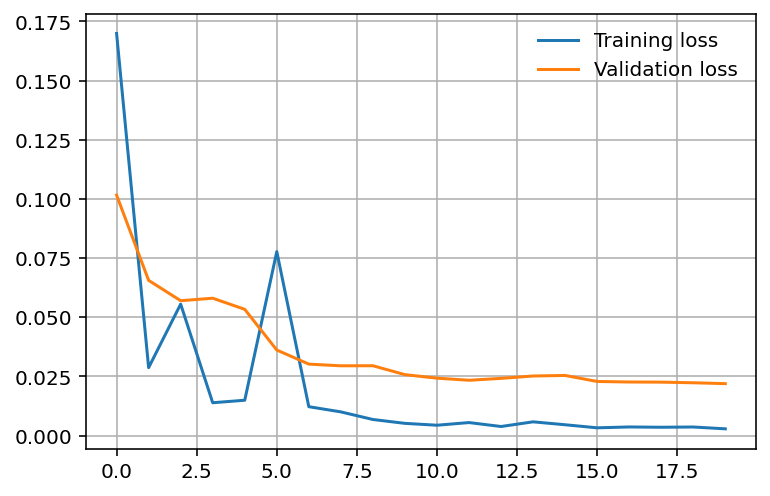

In [35]:
# 성능 분석에 활용하기 위한 결과 plot
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.grid(True)
plt.savefig('loss_graph.png')

In [23]:
def test(test_loader, model, criterion, use_cuda):

    # test loss 를 만들어 줍니다.
    test_loss = 0.0

    # 분류를 성공한 개수를 알려줄 class_correct를 만들어 줍니다.
    class_correct = list(0. for i in range(BUILDING))
    
    # image의 개수를 count하기위해 class_total을 만들어 줍니다.
    class_total = list(0. for i in range(BUILDING))

    # parameter들을 업데이트 하지 않기 때문에 model.eval()
    model.eval()
    
    # testloader에서 image와 label을 가져 옵니다.
    for data, target in tqdm(test_loader):
    
        # CUDA가 사용 가능하다면, GPU로 가져온 data를 옮깁니다.
        if use_cuda:
            data, target = data.cuda(), target.cuda()
    
        # forward pass: model에 image 를 넣고, 결과값을 output에 저장 
        output = model(data)
    
        # batch의 loss를 계산합니다.
        loss = criterion(output, target)
    
        # batch의 loss를 통해 test loss를 update해 줍니다. 
        test_loss += loss.item()*data.size(0)
    
        # batch 단위로 output의 값의 index를 pred에 저장합니다. (class에 해당합니다.)
        _, pred = torch.max(output, 1)  
        
        # pred의 값이 목적값이랑 같다면 true를, 아니라면 false를 correct_tensor에 저장
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        # tensor -> numpy
        correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
        
        # test set의 정확도를 계산
        batch_size = len(target.data)
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # 지금까지 더해왔던 test loss의 평균
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    # test 결과 출력
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

## 학습한 모델에 대한 성능 Test

위에서 학습한 모델을 이용하여 개 이미지의 test dataset에서의 예측결과를 확인하세요.<br>
test loss 와 test accuracy를 계산하고 출력


In [24]:
# call test function    
test(transfer_test_batches, model_transfer, criterion_transfer, use_cuda)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:17<00:00,  1.46s/it]

Test Loss: 0.013315


Test Accuracy (Overall): 99% (1513/1522)


In [27]:
test_path2 = "HBC-5/test_q"
transfer_testing2 = datasets.ImageFolder(test_path2, transform=transfer_test_transforms)
transfer_test_batches2 =  torch.utils.data.DataLoader(transfer_testing2, batch_size=128, shuffle = False)

In [29]:
len(testset)

NameError: name 'testset' is not defined

In [30]:
test(transfer_test_batches2, model_transfer, criterion_transfer, use_cuda)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.47s/it]

Test Loss: 0.043188


Test Accuracy (Overall): 98% (131/133)


In [31]:
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt


def predict(imgpath):
    transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize(MEANS,DEVIATIONS)
                               ])

    img = Image.open(imgpath).convert('RGB')
    plt.imshow(img) # 출력
    img = transform(img)
    img = torch.unsqueeze(img , dim=0)
    
    img = img.to(device)
    with torch.no_grad():
        output = F.log_softmax(model_transfer(img))
    ps = torch.exp(output)
   
    
    
    top_p, top_class = ps.topk(1, dim=1)
    ans = ['공학관', '일송아트홀','산학협력관','대학본부별관', 'clc',]
    print(ans[top_class])
    
    

# 참고자료 목차
- [1]https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html \
   ->BatchNorm2d가 어떤 함수인지
- [2] https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet50 \

 ->Resnet source
- [3]https://bskyvision.com/644 \
  ->Resnet 구조
- [4]http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf \
  ->Resnet 구조
- [5]https://datascienceschool.net/view-notebook/958022040c544257aa7ba88643d6c032/ \
  ->Resnet 구조
- [6]https://iq.opengenus.org/resnet50-architecture/ \
  ->Resnet 구조
- [7]https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e \
  ->batch size 설정팁
- [8]http://aikorea.org/cs231n/neural-networks-2-kr/ \
  ->Normalize를 위한 mean값과 std값은 train set에서만 추출해야함
- [9]https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029 \
  ->Normalize가 필요한 이유
- [10]https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d \
  ->Normalize가 필요한 이유
- [11]https://goodtogreate.tistory.com/entry/Neural-Network-%EC%A0%81%EC%9A%A9-%EC%A0%84%EC%97%90-Input-data%EB%A5%BC-Normalize-%ED%95%B4%EC%95%BC-%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0 \
  ->Normalize가 필요한 이유
- [12]https://www.cs.toronto.edu/~lczhang/321/tut/tut04.pdf \
  -> loss funtion
- [13]http://www.gisdeveloper.co.kr/?p=8668 \
  -> NLLLoss vs CrossEntropyLoss
- [14]https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451 \
  -> Classification - Loss 사진
- [15]https://hyunw.kim/blog/2017/10/26/Cross_Entropy.html \
  -> Cross-Entropy
- [16]https://pytorch.org/hub/pytorch_vision_resnet/ \
  ->학습된 model이 학습할 때 사용한 정규화 값